## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb

* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice.
Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

### 1. Installs & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install simpletransformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationArgs, ClassificationModel


### 2. Dataset Loading & Splitting

In [4]:
# Load only the four specific categories we need
categories = ["alt.atheism", "comp.graphics", "sci.med", "sci.space"]

# Strip out headers, footers, and quoted text to prevent overfitting
train_groups = fetch_20newsgroups(
    subset="train",
    remove=("headers", "footers", "quotes"),
    categories=categories,
    random_state=42,
)
test_groups = fetch_20newsgroups(
    subset="test",
    remove=("headers", "footers", "quotes"),
    categories=categories,
    random_state=42,
)

In [5]:
# Check if identical to notebook 6.4
print("Distribution in Training Set:")
print(dict(sorted(Counter(train_groups.target).items(), key=lambda x: x[0])))
print("\nDistribution in Test Set:")
print(dict(sorted(Counter(test_groups.target).items(), key=lambda x: x[0])))

Distribution in Training Set:
{0: 480, 1: 584, 2: 594, 3: 593}

Distribution in Test Set:
{0: 319, 1: 389, 2: 396, 3: 394}


In [6]:
# Convert the training and test sets to dataframes
train_df = pd.DataFrame({"text": train_groups.data, "labels": train_groups.target})
test_df = pd.DataFrame({"text": test_groups.data, "labels": test_groups.target})

# Split the training set into two, so that 10% of it can be used as validation set
train_df, dev_df = train_test_split(
    train_df, test_size=0.1, random_state=0, stratify=train_df[["labels"]]
)

In [7]:
# Check if identical to notebook 6.4
print("Distribution in Training Set:")
print(dict(sorted(Counter(train_df["labels"]).items(), key=lambda x: x[0])))
print("\nDistribution in Validation Set:")
print(dict(sorted(Counter(dev_df["labels"]).items(), key=lambda x: x[0])))

Distribution in Training Set:
{0: 432, 1: 525, 2: 534, 3: 534}

Distribution in Validation Set:
{0: 48, 1: 59, 2: 60, 3: 59}


### 3. Finetune RoBERTa for Topic Classification on the Dataset

In [8]:
# Model Configuration
model_args = ClassificationArgs()

# Overwrite existing saved models in the same directory
model_args.overwrite_output_dir = True

# Enable evaluation during training to monitor performance
model_args.evaluate_during_training = True

# Training parameters
model_args.num_train_epochs = 10  # Train for 10 epochs
model_args.train_batch_size = 32  # Process 32 samples per batch
model_args.learning_rate = 4e-6  # Learning rate for optimization
model_args.max_seq_length = 256  # Max token length per input (the higher the number, the longer it takes)

# Early stopping helps prevent overfitting by stopping training
# when validation loss stops improving
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01  # Minimum improvement in loss required to continue training
model_args.early_stopping_metric = "eval_loss"  # The metric to monitor
model_args.early_stopping_metric_minimize = True  # Lower eval_loss is better
model_args.early_stopping_patience = 2  # Stop training if no improvement in 2 evaluations

# Run validation every 32 training steps to track progress
model_args.evaluate_during_training_steps = 32

# Change output directory in to be inside Google Drive
model_args.output_dir = "/content/drive/MyDrive/outputs"
model_args.best_model_dir = "/content/drive/MyDrive/outputs/best_model"

In [9]:
model = ClassificationModel(
    model_type = "roberta",
    model_name = "roberta-large",
    num_labels = 4,
    args = model_args,
    use_cuda = torch.cuda.is_available(),
)

print("\n".join(str(model.args).split(",")))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='/content/drive/MyDrive/outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=100
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 l

In [10]:
training_results = model.train_model(train_df, eval_df = dev_df) # this fine tuning takes a lot of time, pls run it and lmk if it works

history = training_results[1]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 5 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 6 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


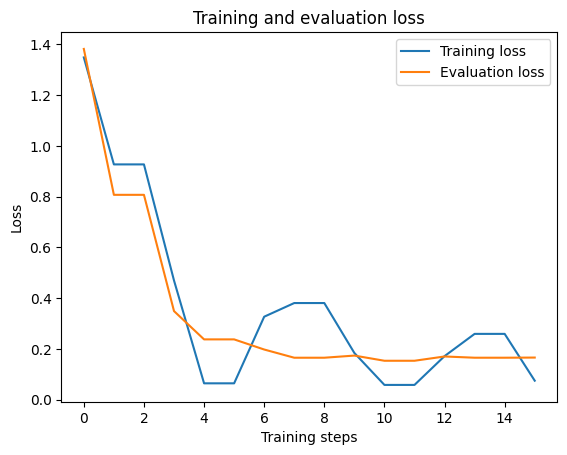

In [11]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.legend()

In [12]:
# Evaluate the model
predicted, probabilities = model.predict(test_df.text.to_list())
test_df_copy = test_df.copy()
test_df_copy['predicted'] = predicted
test_df_copy.head(10)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


,text,labels,predicted
0,\nAnd guess who's here in your place.\n\nPleas...,1,3
1,Does anyone know if any of Currier and Ives et...,1,1
2,=FLAME ON\n=\n=Reading through the posts about...,2,2
3,\nBut in this case I said I hoped that BCCI wa...,0,0
4,\nIn the kind I have made I used a Lite sour c...,2,2
5,"\n\n\tThe ""R Us"" is not trademarked, but the ""...",0,0
6,\nI think you must have the same hygiene teach...,2,2
7,\n\nIt may be a good way to catch a cold. It'...,2,2
8,Archive-name: graphics/resources-list/part2\nL...,1,1
9,can someone tell me where i could find ansi or...,1,1


In [13]:
# Generate classification report
print(classification_report(test_df_copy['labels'], test_df_copy['predicted']))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       319
           1       0.89      0.92      0.91       389
           2       0.90      0.90      0.90       396
           3       0.85      0.87      0.86       394

    accuracy                           0.88      1498
   macro avg       0.88      0.87      0.88      1498
weighted avg       0.88      0.88      0.88      1498



#### *Comparison of Fine-tuned RoBERTa to Fine-Tuned BERT*

![BERT classification report](./BERT_classification_report.png)

`to be added`

### 4. Conventional ML Approach: `specify`

#### SVM with BoW and TF-IDF

In [14]:
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [15]:
# Merging train and validation sets from above as validation set isn't needed with SVM/NB
X_train = pd.concat([train_df["text"], dev_df["text"]])
X_test = test_df["text"]
y_train = pd.concat([train_df["labels"], dev_df["labels"]])
y_test = test_df["labels"]

In [16]:
# BoW
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Initialize and train the SVM
svm_model = svm.LinearSVC()
svm_model.fit(X_train_bow, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_bow)
print(classification_report(y_test, y_pred, target_names=categories))

               precision    recall  f1-score   support

  alt.atheism       0.74      0.70      0.72       319
comp.graphics       0.72      0.84      0.78       389
      sci.med       0.80      0.69      0.74       396
    sci.space       0.71      0.73      0.72       394

     accuracy                           0.74      1498
    macro avg       0.74      0.74      0.74      1498
 weighted avg       0.74      0.74      0.74      1498



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:
# TF-IDF
vectorizer = TfidfVectorizer()
# vectorizer = TfidfVectorizer(min_df=2) -> Slightly better performance
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

# Initialize and train the SVM
svm_model = svm.LinearSVC()
svm_model.fit(X_train_tf, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_tf)
print(classification_report(y_test, y_pred, target_names=categories))

               precision    recall  f1-score   support

  alt.atheism       0.84      0.77      0.80       319
comp.graphics       0.88      0.88      0.88       389
      sci.med       0.88      0.83      0.85       396
    sci.space       0.77      0.86      0.82       394

     accuracy                           0.84      1498
    macro avg       0.84      0.84      0.84      1498
 weighted avg       0.84      0.84      0.84      1498



#### NB with BoW and TF-IDF

In [18]:
# BoW
vectorizer = CountVectorizer()
X_train_bow_nb = vectorizer.fit_transform(X_train)
X_test_bow_nb = vectorizer.transform(X_test)

# Initialize and train the Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_bow_nb, y_train)

# Evaluate the model
y_pred = nb_model.predict(X_test_bow_nb)
print(classification_report(y_test, y_pred, target_names=categories))

               precision    recall  f1-score   support

  alt.atheism       0.78      0.89      0.83       319
comp.graphics       0.91      0.88      0.90       389
      sci.med       0.84      0.90      0.87       396
    sci.space       0.91      0.77      0.84       394

     accuracy                           0.86      1498
    macro avg       0.86      0.86      0.86      1498
 weighted avg       0.87      0.86      0.86      1498



In [19]:
# TF-IDF
vectorizer = TfidfVectorizer()
# vectorizer = TfidfVectorizer(min_df=2) -> Slightly better performance
X_train_tf_nb = vectorizer.fit_transform(X_train)
X_test_tf_nb = vectorizer.transform(X_test)

# Initialize and train the Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tf_nb, y_train)

# Evaluate the model
y_pred = nb_model.predict(X_test_tf_nb)
print(classification_report(y_test, y_pred, target_names=categories))

               precision    recall  f1-score   support

  alt.atheism       0.88      0.71      0.79       319
comp.graphics       0.90      0.87      0.88       389
      sci.med       0.76      0.91      0.83       396
    sci.space       0.83      0.82      0.83       394

     accuracy                           0.83      1498
    macro avg       0.84      0.83      0.83      1498
 weighted avg       0.84      0.83      0.83      1498



#### *Comparison of Fine-Tuned RoBERTa to Conventional ML Approach `specify`*

`to be added`